In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2024 -  United Kingdom Research and Innovation
#  Copyright 2024 -  The University of Manchester
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    CIL contributors 

# CIL Callbacks How To

Callbacks are an essential tool in many optimization frameworks, providing a flexible way to monitor and control the execution of algorithms. Similar to popular packages such as [`keras`](https://keras.io/api/callbacks/), [`scipy`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize), and [`pytorch`](https://pytorch.org/tnt/stable/framework/callbacks.html), CIL utilizes callbacks that can be passed to the `run` method of an algorithm. These callbacks have access to the entire state of the algorithm, allowing them to perform a wide range of tasks—from logging and saving progress to implementing early stopping conditions. By integrating callbacks, users can enhance the flexibility, efficiency, and functionality of their algorithms.

In this demo, we explore the default behavior of callbacks in CIL and present a variety of example callbacks that can be customized to suit your needs. New callbacks are regularly added to CIL based on user requests, so be sure to check out the [documentation](https://tomographicimaging.github.io/CIL/nightly/optimisation/#callbacks) for the latest updates.

## Install CIL and set some defaults

In [2]:

from cil.utilities.display import show2D
from cil.recon import FDK
from cil.processors import TransmissionAbsorptionConverter, Slicer
import numpy as np
import matplotlib.pyplot as plt 
from cil.plugins.tigre import ProjectionOperator
from cil.optimisation.algorithms import FISTA
from cil.optimisation.functions import LeastSquares,  TotalVariation
from cil.optimisation.utilities import callbacks
from cil.framework import DataContainer


# set up default colour map for visualisation
cmap = "gray"

# set the backend for FBP and the ProjectionOperator
device = 'gpu'



## Load Data

In this example, we utilize CIL's simulated sphere data. To accelerate computations in this notebook, we extract a 2D slice from the 3D dataset. Additionally, we select a subset of angles to create a limited-angle reconstruction scenario. We will then compare the ground truth data with a filtered back projection (FBP) reconstruction under these limited-angle conditions.


FDK recon

Input Data:
	angle: 60
	horizontal: 128

Reconstruction Volume:
	horizontal_y: 128
	horizontal_x: 128

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 8
	Filter_inplace: False



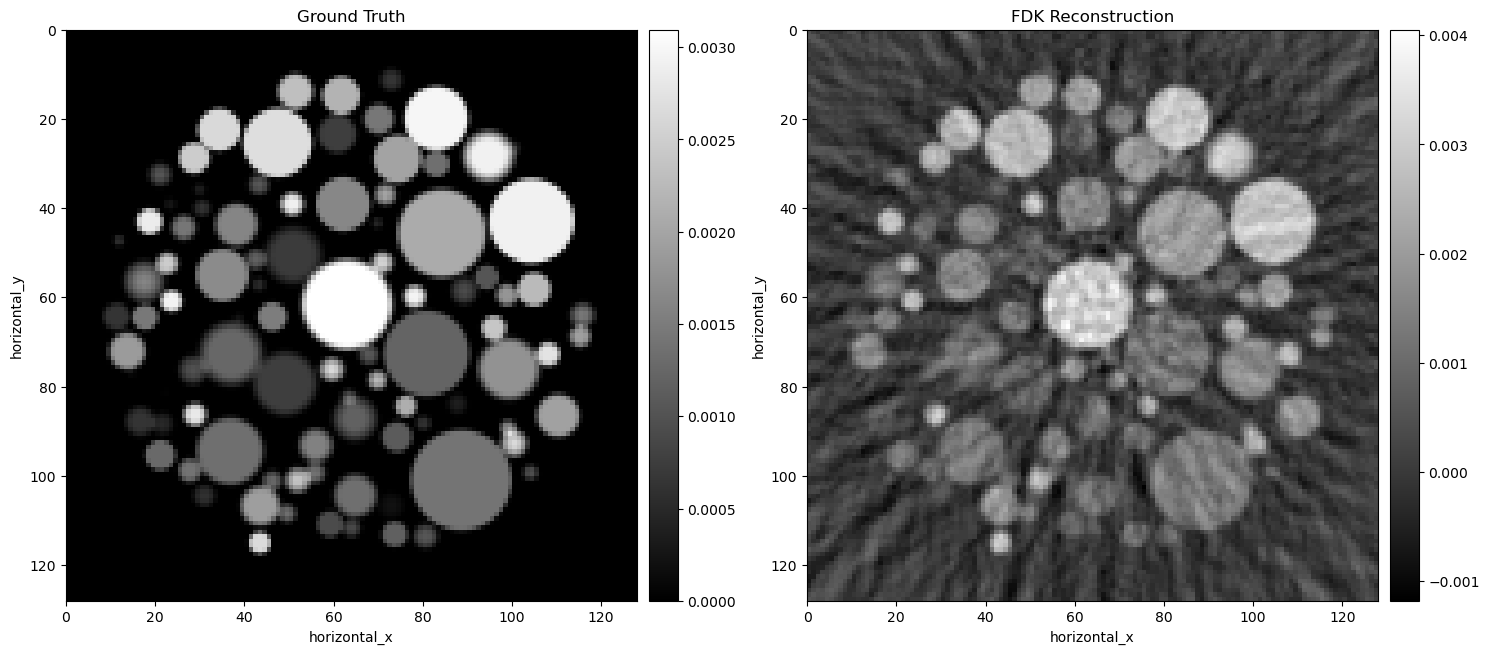

In [3]:
from cil.utilities import dataexample
#%% Load data
ground_truth = dataexample.SIMULATED_SPHERE_VOLUME.get()

data = dataexample.SIMULATED_CONE_BEAM_DATA.get()
twoD = True
if twoD:
    data = data.get_slice(vertical='centre')
    ground_truth = ground_truth.get_slice(vertical='centre')

absorption = TransmissionAbsorptionConverter()(data)
absorption = Slicer(roi={'angle':(0, -1, 5)})(absorption)

ig = ground_truth.geometry

#%%
recon = FDK(absorption, image_geometry=ig).run()
#%%
show2D([ground_truth, recon], title = ['Ground Truth', 'FDK Reconstruction'], origin = 'upper', num_cols = 2)

# %%


## Default Behavior

When no callback is passed to the `run` method, a progress bar is automatically displayed. This progress bar provides useful information, including the time elapsed, estimated time remaining, iterations per second, and the current objective value. Keep in mind that the current objective value updates at intervals determined by the `update_objective_interval` parameter set in the algorithm.


  0%|          | 0/500 [00:00<?, ?it/s]

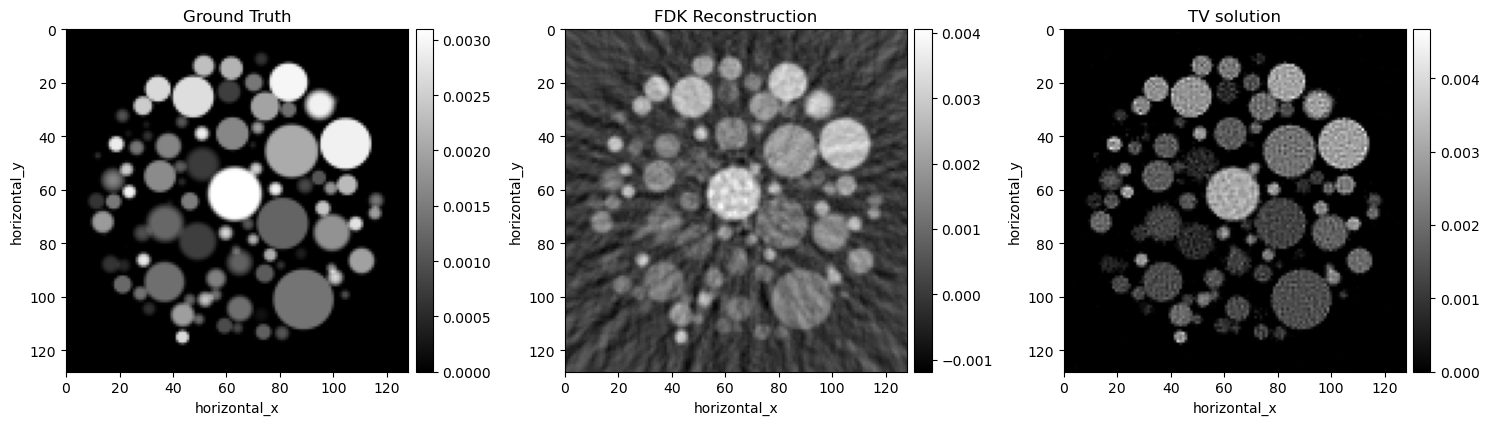

In [4]:
alpha=0.1
A = ProjectionOperator(image_geometry=ig, 
                       acquisition_geometry=absorption.geometry)

F = LeastSquares(A = A, b = absorption)
G = alpha*TotalVariation(lower=0)

algo=FISTA(initial=ig.allocate(0), f=F, g=G, update_objective_interval=1)
algo.run(500)
show2D([ground_truth, recon, algo.solution], title = ['Ground Truth', 'FDK Reconstruction', 'TV solution'], origin = 'upper', num_cols = 3)


## Available CIL Callbacks

Callbacks in CIL are provided as a list to the `run` method of an algorithm. In this example, we use two built-in CIL callbacks: `callbacks.ProgressCallback()` and `callbacks.TextProgressCallback()`. The first is the default callback that displays a progress bar, as demonstrated earlier. The second, `callbacks.TextProgressCallback()`, prints progress updates at intervals specified by `update_objective_interval`.

It's important to note that if you don't pass any callbacks, the default behavior is to display the progress bar. However, if you choose to include other callbacks and still want the progress bar, you must explicitly include `callbacks.ProgressCallback()` in your list.


  0%|          | 0/500 [00:00<?, ?it/s]

     0/500        ?it/s
    10/500    10.67it/s, objective=+8.586e+01
    20/500    10.64it/s, objective=+9.047e+00
    30/500    10.40it/s, objective=+2.640e+00
    40/500    10.38it/s, objective=+1.188e+00
    50/500    10.51it/s, objective=+6.928e-01
    60/500    10.50it/s, objective=+4.585e-01
    70/500    10.72it/s, objective=+3.451e-01
    80/500    10.98it/s, objective=+2.741e-01
    90/500    11.07it/s, objective=+2.337e-01
   100/500    10.98it/s, objective=+2.062e-01
   110/500    10.87it/s, objective=+1.870e-01
   120/500    10.83it/s, objective=+1.729e-01
   130/500    10.83it/s, objective=+1.623e-01
   140/500    10.77it/s, objective=+1.541e-01
   150/500    10.70it/s, objective=+1.476e-01
   160/500    10.57it/s, objective=+1.421e-01
   170/500    10.44it/s, objective=+1.375e-01
   180/500    10.56it/s, objective=+1.336e-01
   190/500    10.44it/s, objective=+1.303e-01
   200/500    10.41it/s, objective=+1.275e-01
   210/500    10.39it/s, objective=+1.250e-01
   220/500

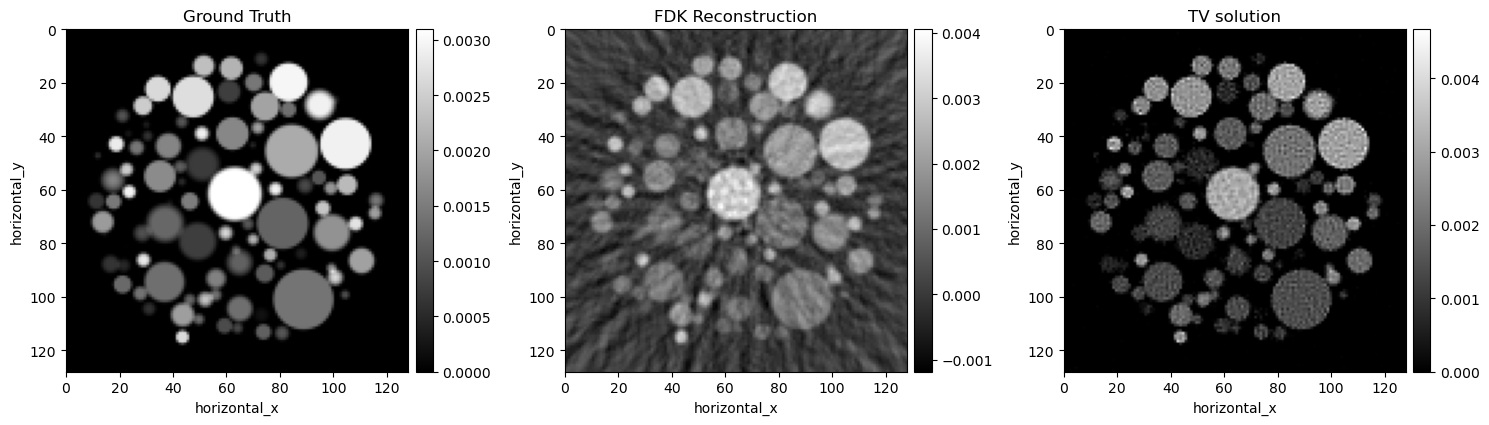

In [5]:
algo=FISTA(initial=ig.allocate(0), f=F, g=G, update_objective_interval=10)
cb1=callbacks.ProgressCallback()
cb2=callbacks.TextProgressCallback()
algo.run(500, callbacks=[cb1, cb2])
show2D([ground_truth, recon, algo.solution], title = ['Ground Truth', 'FDK Reconstruction', 'TV solution'], origin = 'upper', num_cols = 3)


When you call the algorithm's `run` method again, it resumes from where it left off. To start fresh, you should redefine both the algorithm and the callbacks.


In [6]:
algo.run(100, callbacks=[cb1, cb2])

   510/?       8.08it/s, objective=+1.011e-01
   520/?       8.82it/s, objective=+1.008e-01
   530/?       9.28it/s, objective=+1.006e-01
   540/?       9.65it/s, objective=+1.004e-01
   550/?       9.91it/s, objective=+1.002e-01
   560/?      10.12it/s, objective=+1.000e-01
   570/?      10.37it/s, objective=+9.986e-02
   580/?      10.58it/s, objective=+9.969e-02
   590/?      10.56it/s, objective=+9.953e-02
   600/?      10.55it/s, objective=+9.938e-02


## Early Stopping (Custom Callback Example)

To create your own callback, define a class with a `__call__` method. It's a good practice to subclass the CIL `callbacks.Callback` class. The `__call__` method should take `self` and `algorithm` as arguments, where `algorithm` is an initialized CIL algorithm. This allows the callback to access and utilize any properties stored within the algorithm.

In this example, the callback raises a `StopIteration` exception if a specified stopping criterion is met, forcing the algorithm to terminate early. You can see that the algorithm does not run for the full 500 iterations. 


     0/500        ?it/s
    10/500    11.00it/s, objective=+8.586e+01
    20/500    10.72it/s, objective=+9.047e+00
    30/500    10.54it/s, objective=+2.640e+00
    40/500    10.70it/s, objective=+1.188e+00
    50/500    10.55it/s, objective=+6.928e-01
    60/500    10.63it/s, objective=+4.585e-01
    70/500    10.83it/s, objective=+3.451e-01
    80/500    11.06it/s, objective=+2.741e-01
    90/500    10.75it/s, objective=+2.337e-01
   100/500    10.85it/s, objective=+2.062e-01
   110/500    10.91it/s, objective=+1.870e-01
   110/500    10.80it/s



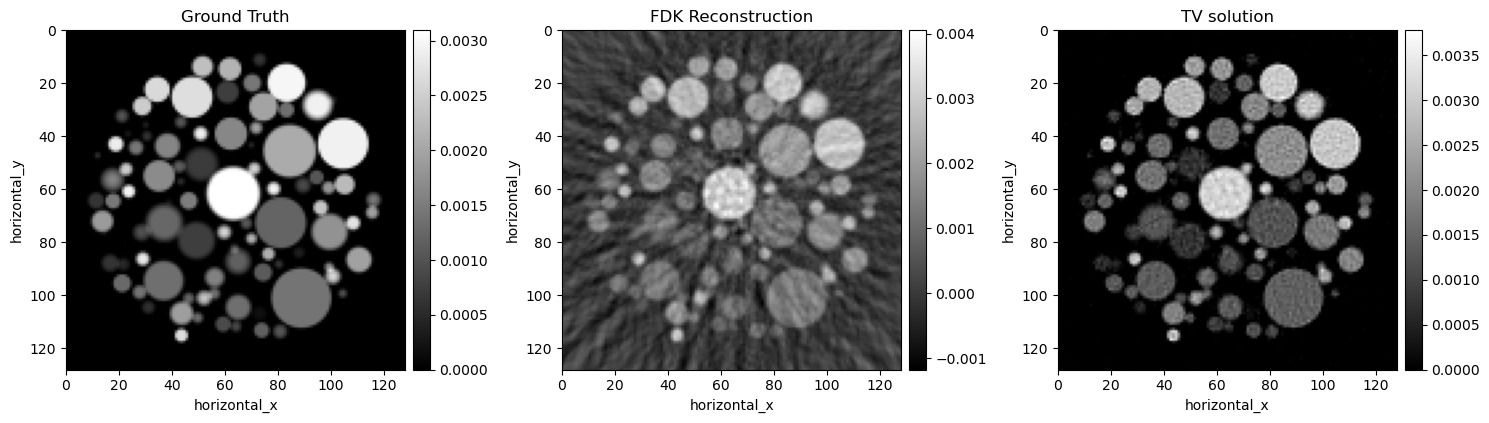

In [7]:
class EarlyStoppingObjective(callbacks.Callback):
         def __call__(self, algorithm):
               if algorithm.objective[-1] <= 2e-1:  # arbitrary stopping criterion
                  raise StopIteration

algo=FISTA(initial=ig.allocate(0), f=F, g=G, update_objective_interval=10)         
algo.run(500, callbacks=[callbacks.TextProgressCallback(), EarlyStoppingObjective()])
show2D([ground_truth, recon, algo.solution], title = ['Ground Truth', 'FDK Reconstruction', 'TV solution'], origin = 'upper', num_cols = 3)


In another early stopping example, the algorithm terminates when the current solution approaches a given reference image. This example demonstrates a callback that accepts arguments upon initialization, allowing for more flexible and customized stopping criteria.


     0/500        ?it/s
    10/500    13.44it/s, objective=+8.586e+01
    20/500    12.77it/s, objective=+9.047e+00
    22/500    12.72it/s



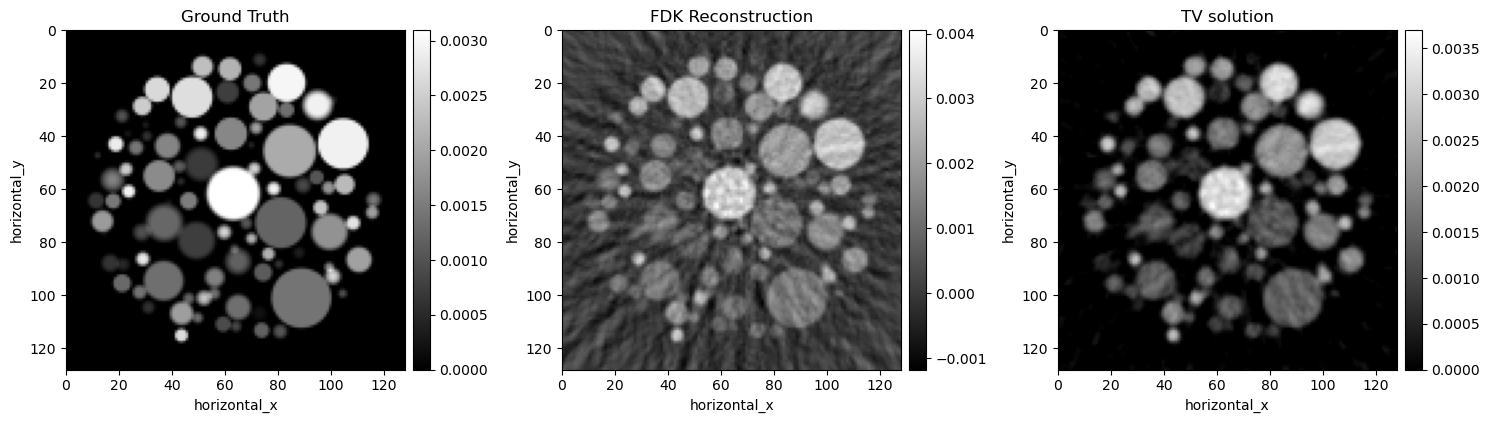

In [8]:
class EarlyStoppingReference(callbacks.Callback):
      def __init__(self, ref_img):
            self.ref=ref_img
      def __call__(self, algorithm):
            if np.mean((algorithm.solution.array-self.ref.array)**2) <= 3e-8:  # arbitrary stopping criterion
                  raise StopIteration

algo=FISTA(initial=ig.allocate(0), f=F, g=G, update_objective_interval=10)
cb=EarlyStoppingReference(ground_truth)         
algo.run(500, callbacks=[callbacks.TextProgressCallback(),cb ])
show2D([ground_truth, recon, algo.solution], title = ['Ground Truth', 'FDK Reconstruction', 'TV solution'], origin = 'upper', num_cols = 3)

## Calculating Data Discrepancy at Each Iteration (Custom Callback Example)

In this example, a custom metric —specifically a least squares data discrepancy calculation— is computed at the end of each iteration and stored within the callback. We demonstrate how to initialize two callbacks to save the results from two different methods: FISTA with TV, with and without a lower bound enforced. The results are then plotted for comparison.


In [9]:
class DataDiscrepancyCallback(callbacks.Callback):
    def __init__(self, A, data):
        self.f = LeastSquares(A, data)
        self.save_values=[]

    def __call__(self, algorithm):
        self.save_values.append(self.f(algorithm.get_output()))

mycallback_FISTA_lower_bound= DataDiscrepancyCallback(A, absorption)
algo1=FISTA(initial=ig.allocate(0), f=F, g=alpha*TotalVariation(lower=0), update_objective_interval=10)         
algo1.run(500, callbacks=[mycallback_FISTA_lower_bound])

        
mycallback_FISTA_no_lower_bound= DataDiscrepancyCallback(A, absorption)
algo2=FISTA(initial=ig.allocate(0), f=F, g=alpha*TotalVariation(), update_objective_interval=10)         
algo2.run(500, callbacks=[mycallback_FISTA_no_lower_bound])


show2D([ground_truth, algo1.get_output(), algo2.get_output()], title=['ground_truth', 'FISTA_lower_bound', 'FISTA_no_lower_bound'], num_cols=3)
show2D([absorption, A.direct(algo1.get_output())-absorption, A.direct(algo2.get_output())-absorption], title=['ground_truth', 'Data error FISTA_lower_bound', 'Data error FISTA_no_lower_bound'], fix_range=[[0,3], [-0.02, 0.02], [-0.02, 0.02]], cmap=['gray', 'seismic', 'seismic'], num_cols=3)
plt.plot(range(10,501), mycallback_FISTA_lower_bound.save_values[10:], label='FISTA TV with lower bound ')
plt.plot(range(10, 501), mycallback_FISTA_no_lower_bound.save_values[10:], label='FISTA TV without lower bound ')
plt.yscale('log')
plt.ylabel('Data discrepancy')
plt.xlabel('Iteration')
plt.legend()

<>:24: SyntaxWarning: invalid escape sequence '\|'
<>:24: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipykernel_3400109/576948973.py:24: SyntaxWarning: invalid escape sequence '\|'
  plt.ylabel('Data discrepancy $\|Ax-y\|_2^2$')
/home/bih17925/miniconda3/envs/cil_24_1_0/lib/python3.12/site-packages/cil/framework/framework.py:3117: RuntimeWarning: invalid value encountered in divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )


We see that the without the lower bound, the reconstruction overfits to the noisy absorption data. 

## Calculating a Noise Approximation for Each Iteration (Custom Callback Example)

In this example, we define a custom callback that saves the values of a wavelet-based estimator of Gaussian noise standard deviation, provided by `skimage`, at each iteration. Using TV regularization and a FISTA optimization algorithm with a lower bound, we compare how the noise level in the solution changes for two different regularization parameters: a small value (0.1) and a larger value (1).


/home/bih17925/miniconda3/envs/cil_24_1_0/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bih17925/miniconda3/envs/cil_24_1_0/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


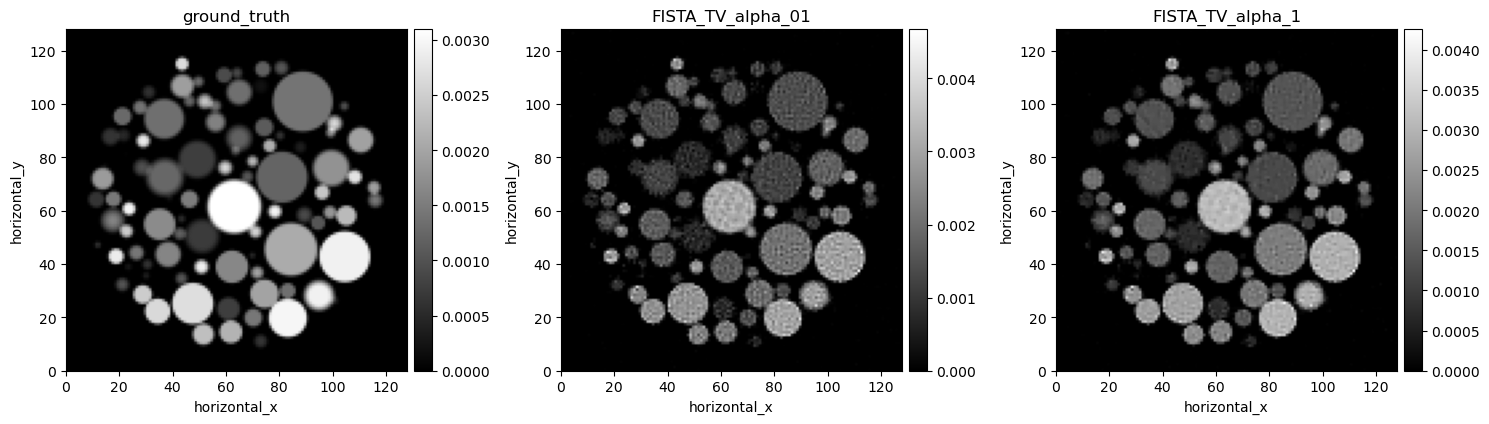

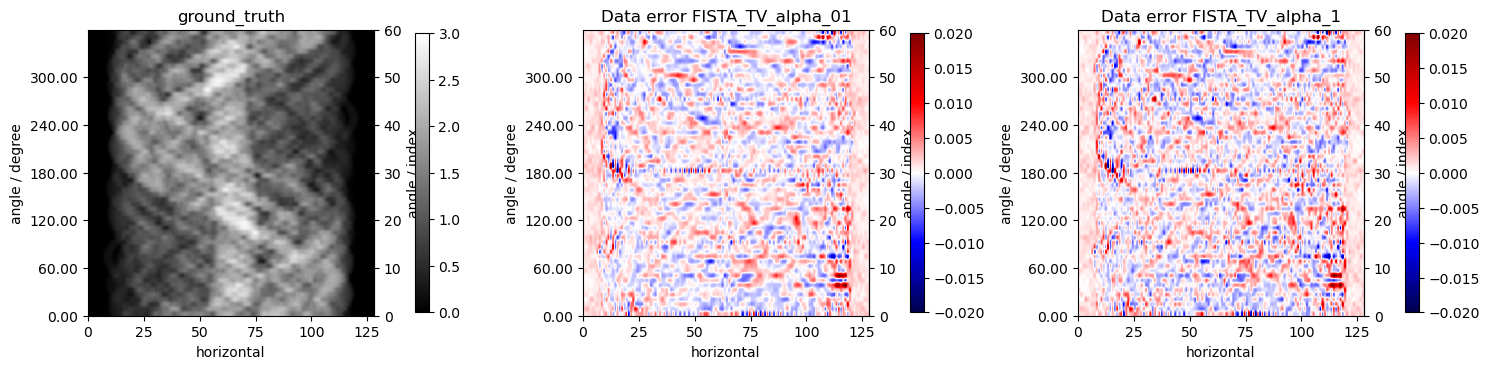

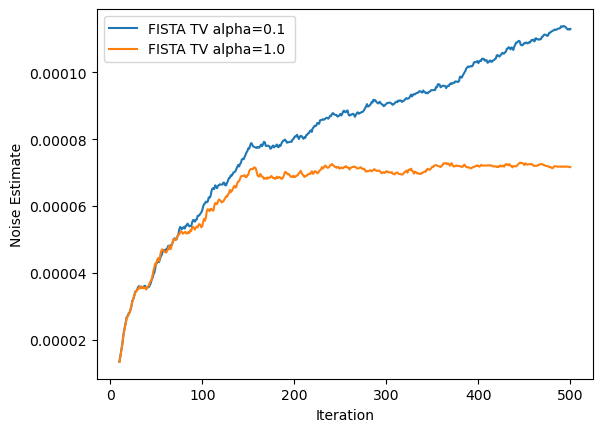

In [ ]:
import skimage

class SigmaEstimateCallback(callbacks.Callback):
    def __init__(self):

        self.save_values=[]

    def __call__(self, algorithm):
        self.save_values.append(skimage.restoration.estimate_sigma(algorithm.get_output().as_array()))

mycallback_FISTA_TV_alpha_01= SigmaEstimateCallback()
algo1=FISTA(initial=ig.allocate(0), f=F, g=0.1*TotalVariation(lower=0), update_objective_interval=10)         
algo1.run(500, callbacks=[mycallback_FISTA_TV_alpha_01])

        
mycallback_FISTA_TV_alpha_1= SigmaEstimateCallback()
algo2=FISTA(initial=ig.allocate(0), f=F, g=1*TotalVariation(lower=0), update_objective_interval=10)         
algo2.run(500, callbacks=[mycallback_FISTA_TV_alpha_1])


show2D([ground_truth, algo1.get_output(), algo2.get_output()], title=['ground_truth', 'FISTA_TV_alpha_01', 'FISTA_TV_alpha_1'], num_cols=3)
show2D([absorption, A.direct(algo1.get_output())-absorption, A.direct(algo2.get_output())-absorption], title=['ground_truth', 'Data error FISTA_TV_alpha_01', 'Data error FISTA_TV_alpha_1'], fix_range=[[0,3], [-0.02, 0.02], [-0.02, 0.02]], cmap=['gray', 'seismic', 'seismic'], num_cols=3)
plt.plot(range(10,501), mycallback_FISTA_TV_alpha_01.save_values[10:], label='FISTA TV alpha=0.1 ')
plt.plot(range(10, 501), mycallback_FISTA_TV_alpha_1.save_values[10:], label='FISTA TV alpha=1.0 ')
plt.ylabel('Noise Estimate')
plt.xlabel('Iteration')
plt.legend()
                                   
                            

We see with a larger regularisation parameter, the resulting image is less noisy. 

## Image metric callbacks (complex custom callback example) 
We now move on to some more complex callbacks. In this callback, a dictionary of metrics are calculated and printed each `print_interval`. 

In [ ]:

class MetricsDiagnostics(callbacks.Callback):
    """
      Parameters
    ----------

    reference_image: CIL or STIR ImageData
      containing the reference image used to calculate the metrics

      
    metrics_dict : dictionary of lambda functions f(x,y) mapping
      two 1-dimensional numpy arrays x and y to a scalar value or a
      numpy.ndarray.
      x and y can be the voxel values of the whole images or the values of
      voxels in a ROI such that the metric can be computed on the whole
      images and optionally in the ROIs separately.

      E.g. f(x,y) could be MSE(x,y), PSNR(x,y), MAE(x,y)
      
    print_interval: positive integer
        The results are calculated and printed every `print_interval` number of iterations 


    """

    def __init__(self, reference_image, metrics_dict, print_interval=1):

        # reference image as numpy (level) array
        self.reference_image = reference_image      
        self.metrics_dict = metrics_dict
        # if data_range is None:
            # self.data_range = np.abs(self.reference_image.max() - self.reference_image.min())
        self.computed_metrics = []    
        self.print_interval=print_interval

        super(MetricsDiagnostics, self).__init__()  

    def __call__(self, algo):

            
        for metric_name, metric_func in self.metrics_dict.items():

            if not hasattr(algo, metric_name):
                setattr(algo, metric_name, [])   
                
            metric_list = getattr(algo, metric_name)
            metric_value = metric_func(self.reference_image, algo.get_output())
            metric_list.append(metric_value)
            
            self.computed_metrics.append(metric_value)
            
        if algo.iteration == 0:
                    
            print (self.callback_header())
        
        print(self.callback_iteration())  
            
               
    def callback_header(self):
        return " ".join("{:>20}".format(metric_name) for metric_name in self.metrics_dict.keys())

    def callback_iteration(self):
        if isinstance(self.computed_metrics, list):
            # Handle list of metrics
            return " ".join("{:>20.5e}".format(metric) for metric in self.computed_metrics[-len(self.metrics_dict):])
        else:
            # Handle single metric
            return "{:>20.5e}".format(self.computed_metrics)     
        

from cil.utilities.quality_measures import mae, psnr, mse 
metric_callback= MetricsDiagnostics(ground_truth, {'MSE':mse, 'MAE':mae, 'PSNR':psnr})
algo=FISTA(initial=ig.allocate(0), f=F, g=G, update_objective_interval=10)         
algo.run(100, callbacks=[metric_callback])

                 MSE                  MAE                 PSNR
         1.07888e-06          5.48145e-04          9.48530e+00
         5.85316e-07          6.22034e-04          1.21411e+01
         5.05844e-07          5.72563e-04          1.27749e+01
         4.31374e-07          5.19819e-04          1.34665e+01
         3.64704e-07          4.67054e-04          1.41956e+01
         3.06416e-07          4.16492e-04          1.49519e+01
         2.56388e-07          3.70092e-04          1.57261e+01
         2.14156e-07          3.28810e-04          1.65077e+01
         1.78987e-07          2.92725e-04          1.72868e+01
         1.50022e-07          2.60981e-04          1.80535e+01
         1.26383e-07          2.33361e-04          1.87981e+01
         1.07187e-07          2.09652e-04          1.95136e+01
         9.16141e-08          1.89309e-04          2.01954e+01
         7.89449e-08          1.72049e-04          2.08418e+01
         6.85910e-08          1.57283e-04          2.14

## Image metric callbacks with region of interest (complex custom callback example) 

For another complex example. This callback takes a reference image, region of interest mask and a dictionary of metrics and a dictionary of statisitcs to evaluate at each iteration. We define some regions of interest and then can plot the metrics for the different regions of interest. 

In [ ]:
class ImageQualityCallback(callbacks.Callback):
    """
      Parameters
    ----------

    reference_image: CIL or STIR ImageData
      containing the reference image used to calculate the metrics

    roi_mask_dict : dictionary of ImageData objects
      list containing one binary ImageData object for every ROI to be
      evaluated. Voxels with values 1 are considered part of the ROI
      and voxels with value 0 are not.
      Dimension of the ROI mask images must be the same as the dimension of
      the reference image.
      
    metrics_dict : dictionary of lambda functions f(x,y) mapping
      two 1-dimensional numpy arrays x and y to a scalar value or a
      numpy.ndarray.
      x and y can be the voxel values of the whole images or the values of
      voxels in a ROI such that the metric can be computed on the whole
      images and optionally in the ROIs separately.

      E.g. f(x,y) could be MSE(x,y), PSNR(x,y), MAE(x,y)

    statistics_dict : dictionary of lambda functions f(x) mapping a 
      1-dimensional numpy array x to a scalar value or a numpy.ndarray.
      E.g. mean(x), std_deviation(x) that calculate global and / or
      ROI mean and standard deviations.

      E.g. f(x) could be x.mean()




      """
      
    def __init__(self, reference_image, 
                       roi_mask_dict   = None,
                       metrics_dict    = None,
                       statistics_dict = None,
                       ):

        # the reference image
        self.reference_image = reference_image


        self.roi_indices_dict = {}
        self.roi_store=[]



        self.roi_mask_dict=roi_mask_dict
        
        
        self.metrics_dict = metrics_dict
        self.metrics_store={}
        for key, value in self.metrics_dict.items():
                self.metrics_store['global_'+key] = []
                if roi_mask_dict is not None:
                  for roi_name, value in roi_mask_dict.items():
                    self.metrics_store[roi_name+'_'+key] = []

        self.statistics_dict = statistics_dict
        self.stat_store={}
        for key, value in self.statistics_dict.items():
                self.stat_store['global_'+key] = []
                if roi_mask_dict is not None:
                  for roi_name, value in roi_mask_dict.items():
                    self.stat_store[roi_name+'_'+key] = []
                
    def __call__(self, algorithm):
            if self.metrics_dict is not None:
                for metric_name, metric in self.metrics_dict.items():
                    ans = metric(self.reference_image, algorithm.x)
                    self.metrics_store['global_'+metric_name].append(ans)
                    
                    
                    for roi_name, roi in self.roi_mask_dict.items():
                      ans = metric(self.reference_image, algorithm.x, mask=roi)
                      self.metrics_store[roi_name+'_'+metric_name].append(ans)
                       
                    
                    
            if self.statistics_dict is not None:
                for statistic_name, stat in self.statistics_dict.items():
                    ans = stat( algorithm.x.array, np._NoValue)
                    self.stat_store['global_'+statistic_name].append(ans)
                    
                    
                    for roi_name, roi in self.roi_mask_dict.items():
                        ans = stat( algorithm.x.array, roi.array.astype('bool'))
                        self.stat_store[roi_name+'_'+statistic_name].append(ans)
                        
        
                    
                    
       



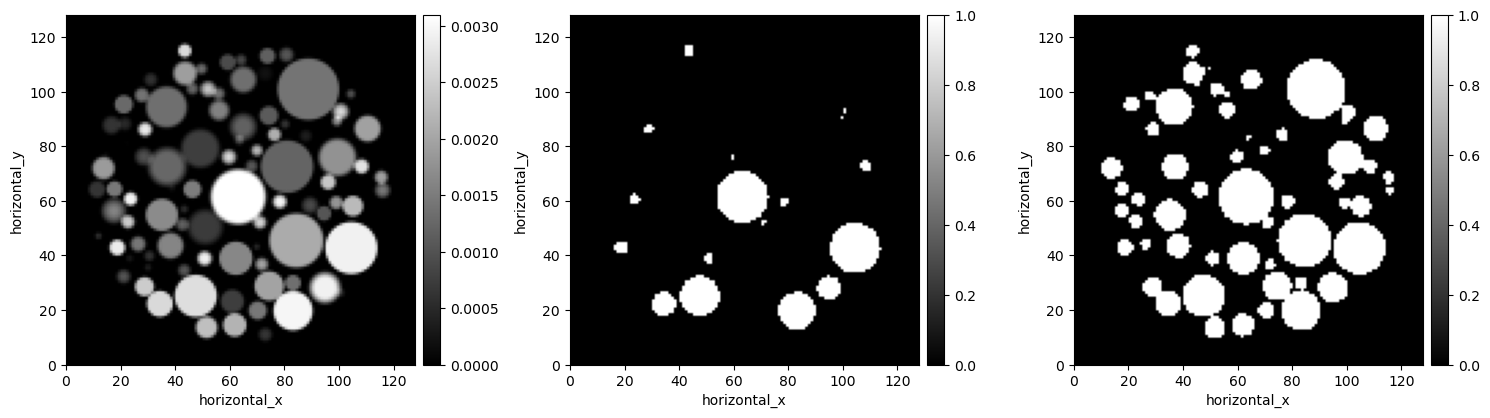

In [ ]:
#%% create masks
top = ig.allocate(0)
bottom = ig.allocate(0)

top.fill(
    np.asarray(ground_truth.array > 0.8 * ground_truth.max(), 
               dtype=np.float32)
    )
bottom.fill(
    np.asarray(np.invert(ground_truth.array < 0.4 * ground_truth.max()), 
               dtype=np.float32)
)



roi_image_dict = {
    'top' : top,
    'bottom' : bottom
}

show2D([ground_truth, top, bottom], num_cols=3)

In [ ]:
from cil.utilities.quality_measures import mae, psnr, mse 
img_qual_callback = ImageQualityCallback(ground_truth,
                                              roi_mask_dict = roi_image_dict,
                                              metrics_dict = {'MSE':mse, 
                                                              'MAE':mae, 
                                                              'PSNR':psnr},
                                              statistics_dict = {'MEAN': (lambda x, y: np.mean(x, where=y)),
                                                                 'STDDEV': (lambda x, y: np.std(x, where=y)),
                                                                 'MAX': (lambda x, y: np.max(x, where=y, initial=0))},
                                              )

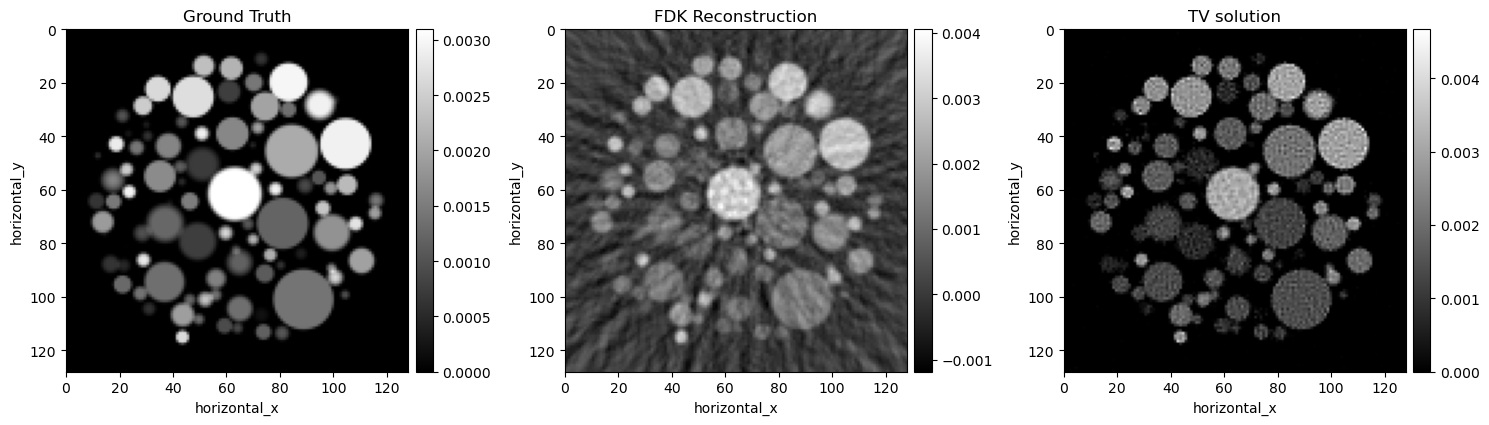

In [ ]:
algo=FISTA(initial=ig.allocate(0), f=F, g=G, update_objective_interval=10)         
algo.run(500, callbacks=[img_qual_callback])
show2D([ground_truth, recon, algo.solution], title = ['Ground Truth', 'FDK Reconstruction', 'TV solution'], origin = 'upper', num_cols = 3)

Text(0.5, 1.0, 'Mean squared error against iteration number')

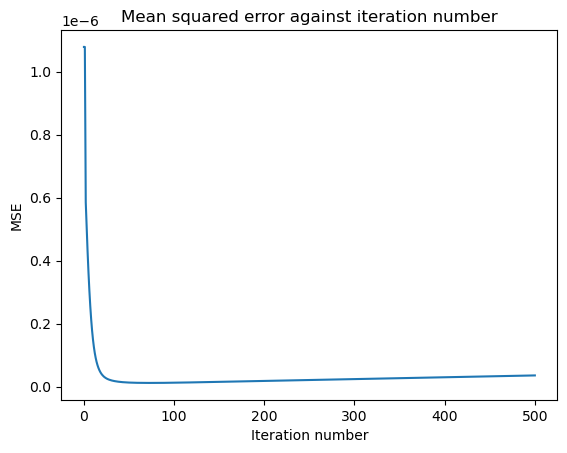

In [ ]:
plt.plot(range(501), img_qual_callback.metrics_store['global_MSE'])
plt.ylabel('MSE')
plt.xlabel('Iteration number')
plt.title('Mean squared error against iteration number')


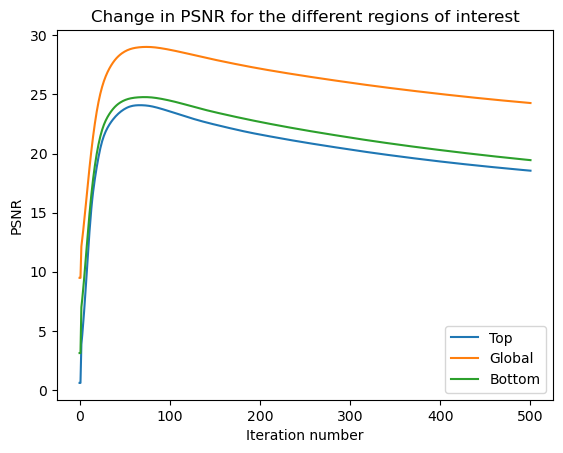

In [ ]:
plt.plot(range(501), img_qual_callback.metrics_store['top_PSNR'], label='Top')
plt.plot(range(501), img_qual_callback.metrics_store['global_PSNR'], label='Global')
plt.plot(range(501), img_qual_callback.metrics_store['bottom_PSNR'], label='Bottom')
plt.xlabel('Iteration number')
plt.ylabel('PSNR')
plt.title(' PSNR for the different regions of interest')
plt.legend()